In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

Using TensorFlow backend.


In [4]:
from sklearn.preprocessing import StandardScaler
from keras import metrics
import json

In [5]:
def inverse_stationize(df_pred, data):
    size = df_pred.shape[1]
    inv_data = {}
    for k in data.keys():
        inv_data[int(k)] = df_pred[int(k)] * data[k]['rolling_std'][-size:] + data[k]['rolling_mean'][-size:]
    return inv_data

In [6]:
with open('data_stationized.json') as jf:
    data_json = json.load(jf)

In [7]:
test_final = pd.read_csv('../wrangled_data/testing_post_wrangle_small.csv')
test_final = test_final.loc[:,['ID', 'shop_id', 'item_id']]

In [8]:
train = pd.read_csv('./stationized_dataframe_lag3_rerun.csv')
train

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,1.154701,-1.732051,-1.577350,-0.577350,2.309401,1.154701,0.000000,0.000000,-1.154701,-0.872872
1,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.154701,0.218218,-1.091089,-1.154701,0.872872,0.513739
3,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.154701,-0.577350,-0.577350
4,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,-0.872872,-1.732051,-1.154701,0.295521,0.577350,1.154701,0.577350,0.000000,1.154701
214196,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
214197,NaN,NaN,NaN,NaN,NaN,0.57735,0.0,0.0,0.0,0.0,...,1.154701,0.577350,-1.154701,-1.732051,-0.577350,1.154701,0.577350,0.000000,0.000000,0.000000
214198,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
train = train.dropna(axis=1)

In [10]:
train

,5,6,7,8,9,10,11,12,13,14,...,24,25,26,27,28,29,30,31,32,33
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,1.154701,-1.732051,-1.577350,-0.577350,2.309401,1.154701,0.000000,0.000000,-1.154701,-0.872872
1,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.154701,0.218218,-1.091089,-1.154701,0.872872,0.513739
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.154701,-0.577350,-0.577350
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,-0.872872,-1.732051,-1.154701,0.295521,0.577350,1.154701,0.577350,0.000000,1.154701
214196,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
214197,0.57735,0.0,0.0,0.0,0.0,1.154701,-0.57735,-0.57735,-1.154701,0.57735,...,1.154701,0.577350,-1.154701,-1.732051,-0.577350,1.154701,0.577350,0.000000,0.000000,0.000000
214198,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [12]:
X_train = train_scaled[:,:-1]
X_predict = train_scaled[:,1:]
y_train = train_scaled[:,-1]

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 28) (214200,) (214200, 28)


In [13]:
X_train = X_train.reshape((214200, 1, -1))
X_predict = X_predict.reshape((214200, 1, -1))
y_train = y_train.reshape((214200, -1))

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 1, 28) (214200, 1) (214200, 1, 28)


In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.compile(loss = 'mse',  # 'mean_squared_logarithmic_error', binary_crossentropy
                   optimizer = 'Adam',  # 'Nadam', 'adam', 'RMSprop', 'Ftrl', 'Adamax', 'Adagrad', 'Adadelta', 'SGD'
                   metrics = ['mean_squared_error'])  # 'mean_tensor', 'kullback_leibler_divergence', 'mean_squared_error', 'mean_absolute_error', 'logcosh', 'cosine_proximity', 'cosine_similarity'
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            80384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              129       
Total params: 80,513
Trainable params: 80,513
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, batch_size = 4096, epochs = 50)

[2021-08-23 08:49:21.070 ip-172-16-15-36:7936 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-23 08:49:21.094 ip-172-16-15-36:7936 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 214200 samples
Epoch 1/50
214200/214200 [==============================] - 3s 15us/sample - loss: 0.8883 - mean_squared_error: 0.8883
Epoch 2/50
214200/214200 [==============================] - 1s 6us/sample - loss: 0.6631 - mean_squared_error: 0.6631
Epoch 3/50
214200/214200 [==============================] - 1s 6us/sample - loss: 0.5364 - mean_squared_error: 0.5364
Epoch 4/50
214200/214200 [==============================] - 1s 6us/sample - loss: 0.4956 - mean_squared_error: 0.4956
Epoch 5/50
214200/214200 [==============================] - 1s 7us/sample - loss: 0.4805 - mean_squared_error: 0.4805
Epoch 6/50
214200/214200 [==============================] - 1s 7us/sample - loss: 0.4731 - mean_squared_error: 0.4

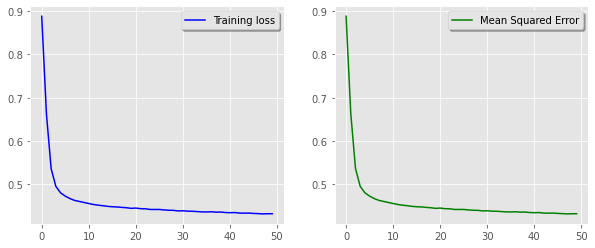

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mean_squared_error'], color='g', label='Mean Squared Error')
ax[1].legend(loc='best', shadow=True)

In [34]:
# creating submission file 
submission_pfs = model.predict(X_predict)

In [35]:
X_predict.shape

(214200, 1, 28)

In [36]:
submission_pfs.shape

(214200, 1, 1)

In [37]:
submission_pfs.shape

(214200, 1, 1)

In [38]:
submit_scaled = np.hstack((X_predict.reshape(214200, -1), submission_pfs.reshape(214200, -1)))

In [39]:
submit_scaled.shape

(214200, 29)

In [40]:
submit_scaled[:,28]

array([-2.14434648,  0.12721272, -0.65901053, ...,  0.424182  ,
        0.12721272,  0.19301286])

In [41]:
submit_stationary = scaler.inverse_transform(submit_scaled)
submit_stationary.shape

(214200, 29)

In [42]:
submit = pd.DataFrame(inverse_stationize(submit_stationary, data_json)).T
# submit = pd.DataFrame(submit_stationary)

In [43]:
submit.shape

(214200, 29)

In [44]:
# we will keep every value between 0 and 20
submit = submit.clip(0,20)

In [45]:
submit.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.001656,0.017717,0.0,0.0,0.0,0.043572,0.01153,0.007374,0.0,...,0.735962,0.000000,0.0,3.348184e-08,0.999389,0.655007,1.000000,0.406427,0.684274,0.000000
1,0.0,0.001656,0.017717,0.0,0.0,0.0,0.043572,0.01153,0.007374,0.0,...,0.036137,0.015138,0.0,0.000000e+00,0.017132,0.000000,0.002481,0.046168,0.000000,0.060228
2,0.0,0.001656,0.017717,0.0,0.0,0.0,0.043572,0.01153,0.007374,0.0,...,0.036137,0.015138,0.0,1.107881e+00,1.401683,0.000000,0.000000,1.906088,2.088653,1.214157
3,0.0,0.001656,0.017717,0.0,0.0,0.0,0.043572,0.01153,0.007374,0.0,...,0.036137,0.015138,0.0,0.000000e+00,0.017132,0.000000,1.138576,0.031601,0.007667,0.000000
4,0.0,0.001656,0.017717,0.0,0.0,0.0,0.043572,0.01153,0.007374,0.0,...,0.036137,0.015138,0.0,0.000000e+00,0.017132,0.000000,0.002481,0.046168,0.000000,0.060228


In [46]:
submit.loc[:,28]

0         0.000000
1         0.060228
2         1.214157
3         0.000000
4         0.060228
            ...   
214195    0.178080
214196    0.060228
214197    0.230998
214198    0.060228
214199    0.098066
Name: 28, Length: 214200, dtype: float64

In [47]:
# creating dataframe with required columns 
submit = pd.DataFrame({'ID':test_final['ID'],'item_cnt_month':submit.loc[:,28]})
# creating csv file from dataframe
submit.to_csv('../submission_files/stationary_inver_lstm_lag3_stdscaler_rerun.csv',index = False)

In [48]:
submit.head(3)

,ID,item_cnt_month
0,0,0.000000
1,1,0.060228
2,2,1.214157


In [49]:
submit.shape

(214200, 2)